In [2]:
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
import rosbag
import pandas as pd
from scipy import integrate
from scipy.interpolate import interp1d
from IPython.display import display
from mpldatacursor import datacursor
import time
import math
#from SimpleCV import Display, Image, Color
import cv2
from cv_bridge import CvBridge
import sys, getopt
import Equirec2Perspec as E2P 

In [6]:
filename='2019-02-26-13-34-08'

bag  = rosbag.Bag('/home/maleen/' + filename + '.bag')

In [7]:

ricoh_time=np.array([])
ricoh_seq=np.array([])
img=np.array([])
ricohsize=0



topiclist=['/camera/image_raw']

for topic, msg, t in bag.read_messages(topics=topiclist): #
    
        if topic=='/camera/image_raw':
            
            ricoh_time=np.append(ricoh_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            ricoh_seq=np.append(ricoh_seq,msg.header.seq)
            
            img=np.append(img,msg)
            
            ricohsize=ricohsize+1
            
            

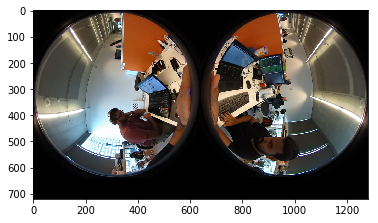

True

In [15]:
bridge = CvBridge()

cv_image = bridge.imgmsg_to_cv2(img[500], desired_encoding="passthrough")

#plt.imshow(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
plt.imshow(cv_image)

plt.show()

cv2.imwrite('tes.jpg', cv_image)

In [6]:
'''

def spliceImg(img,doCrop=False):
    # Cut the input image into four chunks and return the results
    section = img.shape[1]/4;
    retVal = []
    for i in range(0,4):
        temp = img[0:img.shape[0],section*i:section]
        if( doCrop ):
            mask = temp.threshold(20)
            b = temp.findBlobsFromMask(mask)
            temp = b[-1].hullImage()
            m = np.max([temp.shape[1],temp.shape[0]])
            temp = temp.resize(m,m)
        retVal.append(temp)
    return retVal

def buildMap(Ws,Hs,Wd,Hd,hfovd=160.0,vfovd=160.0):
    # Build the fisheye mapping
    map_x = np.zeros((Hd,Wd),np.float32)
    map_y = np.zeros((Hd,Wd),np.float32)
    vfov = (vfovd/180.0)*np.pi
    hfov = (hfovd/180.0)*np.pi
    vstart = ((180.0-vfovd)/180.00)*np.pi/2.0
    hstart = ((180.0-hfovd)/180.00)*np.pi/2.0
    count = 0
    # need to scale to changed range from our
    # smaller cirlce traced by the fov
    xmax = np.sin(np.pi/2.0)*np.cos(vstart)
    xmin = np.sin(np.pi/2.0)*np.cos(vstart+vfov)
    xscale = xmax-xmin
    xoff = xscale/2.0
    zmax = np.cos(hstart)
    zmin = np.cos(hfov+hstart)
    zscale = zmax-zmin
    zoff = zscale/2.0
    # Fill in the map, this is slow but
    # we could probably speed it up
    # since we only calc it once, whatever
    for y in range(0,int(Hd)):
        for x in range(0,int(Wd)):
            count = count + 1
            phi = vstart+(vfov*((float(x)/float(Wd))))
            theta = hstart+(hfov*((float(y)/float(Hd))))
            xp = ((np.sin(theta)*np.cos(phi))+xoff)/zscale#
            zp = ((np.cos(theta))+zoff)/zscale#
            xS = Ws-(xp*Ws)
            yS = Hs-(zp*Hs)
            map_x.itemset((y,x),int(xS))
            map_y.itemset((y,x),int(yS))


    return map_x, map_y

def unwarp(img,xmap,ymap):
    # apply the unwarping map to our image
    output = cv2.remap(img,xmap,ymap,cv2.INTER_LINEAR)
    #result = Image(output,cv2image=True)
    result=output
    return result

def postCrop(img,threshold=10):
    # Crop the image after dewarping
    return img[img.shape[0]*0.1:img.shape[0]*0.8,img.shape[1]*0.2:img.shape[1]*.6]


def findHomography(img,template,quality=500.00,minDist=0.2,minMatch=0.4):
    # cribbed from SimpleCV, the homography sucks for this
    # just use the median of the x offset of the keypoint correspondences
    # to determine how to align the image
    skp,sd = img._getRawKeypoints(quality)
    tkp,td = template._getRawKeypoints(quality)
    if( skp == None or tkp == None ):
        warnings.warn("I didn't get any keypoints. Image might be too uniform or blurry." )
        return None

    template_points = float(td.shape[0])
    sample_points = float(sd.shape[0])
    magic_ratio = 1.00
    if( sample_points > template_points ):
        magic_ratio = float(sd.shape[0])/float(td.shape[0])

    idx,dist = img._getFLANNMatches(sd,td) # match our keypoint descriptors
    p = dist[:,0]
    result = p*magic_ratio < minDist 
    pr = result.shape[0]/float(dist.shape[0])

    if( pr > minMatch and len(result)>4 ): # if more than minMatch % matches we go ahead and get the data
        #FIXME this code computes the "correct" homography
        lhs = []
        rhs = []
        for i in range(0,len(idx)):
            if( result[i] ):
                lhs.append((tkp[i].pt[1], tkp[i].pt[0]))             #FIXME note index order
                rhs.append((skp[idx[i]].pt[0], skp[idx[i]].pt[1]))   #FIXME note index order

        rhs_pt = np.array(rhs)
        lhs_pt = np.array(lhs)
        xm = np.median(rhs_pt[:,1]-lhs_pt[:,1])
        ym = np.median(rhs_pt[:,0]-lhs_pt[:,0])
        homography,mask = cv2.findHomography(lhs_pt,rhs_pt,cv2.RANSAC, ransacReprojThreshold=1.1 )
        return (homography,mask, (xm,ym))
    else:
        return None
    
def constructMask(w,h,offset,expf=1.2):
    # Create an alpha blur on the left followed by white
    # using some exponential value to get better results
    mask = Image((w,h))
    offset = int(offset)
    for i in range(0,offset):
        factor =np.clip((float(i)**expf)/float(offset),0.0,1.0) 
        c = int(factor*255.0)
        #this is oddness in slice, need to submit bug report
        mask[i:i+1,0:h] = (c,c,c)

    mask.drawRectangle(offset,0,w-offset,h,color=(255,255,255),width=-1)
    mask = mask.applyLayers()
    return mask
    
def buildPano(defished):
    # Build the panoram from the defisheye images
    offsets = []
    finalWidth = defished[0].shape[1]
    # Get the offsets and calculte the final size
    for i in range(0,len(defished)-1):
        H, M, offset = findHomography(defished[i],defished[i+1])
        dfw = defished[i+1].shape[1]
        offsets.append(offset)
        finalWidth += int(dfw-offset[0])

    final = Image((finalWidth,defished[0].shape[0]))
    final = final.blit(defished[0],pos=(0,0))
    xs = 0
    # blit subsequent images into the final image
    for i in range(0,len(defished)-1):
        w = defished[i+1].shape[1]
        h = defished[i+1].shape[0]
        mask = constructMask(w,h,offsets[i][0])
        xs += int(w-offsets[i][0])
        final = final.blit(defished[i+1],pos=(xs,0),alphaMask=mask)
    return final


'''

In [159]:

'''

doPostCrop = True
img =cv_image
sections = spliceImg(img,not doPostCrop)
temp = sections[0]
    # we may want to make a new map per image for better
    # results in the long run
    # You can change these parameters to get different sized
    # outputs
Ws = temp.shape[1]
Hs = temp.shape[0]
Wd = temp.shape[1]*(4.0/3.0)
Hd = temp.shape[0]
print "BUILDING MAP..."
mapx,mapy = buildMap(Ws,Hs,Wd,Hd)
print "MAP DONE"
defished = []
# do our dewarping and save/show the results
for s,idx  in zip(sections,range(0,len(sections))):
    result = unwarp(s,mapx,mapy)
    if(doPostCrop):
        result = postCrop(result)
    #    result = result.edges()
    defished.append(result)
    temp = result
    #temp.save("{0}View{1}.png".format(outputdir,idx))
    #result.save("{0}DeWarp{1}.png".format(outputdir,idx))
    temp.show()
    #time.sleep(1)
    # Build the pano 
#final = buildPano(defished)
#final.show()
#final.save('{0}final.png'.format(outputdir))
#time.sleep(10)


'''


#plt.imshow(sections[0])
#plt.show()

'\n\ndoPostCrop = True\nimg =cv_image\nsections = spliceImg(img,not doPostCrop)\ntemp = sections[0]\n    # we may want to make a new map per image for better\n    # results in the long run\n    # You can change these parameters to get different sized\n    # outputs\nWs = temp.shape[1]\nHs = temp.shape[0]\nWd = temp.shape[1]*(4.0/3.0)\nHd = temp.shape[0]\nprint "BUILDING MAP..."\nmapx,mapy = buildMap(Ws,Hs,Wd,Hd)\nprint "MAP DONE"\ndefished = []\n# do our dewarping and save/show the results\nfor s,idx  in zip(sections,range(0,len(sections))):\n    result = unwarp(s,mapx,mapy)\n    if(doPostCrop):\n        result = postCrop(result)\n    #    result = result.edges()\n    defished.append(result)\n    temp = result\n    #temp.save("{0}View{1}.png".format(outputdir,idx))\n    #result.save("{0}DeWarp{1}.png".format(outputdir,idx))\n    temp.show()\n    #time.sleep(1)\n    # Build the pano \n#final = buildPano(defished)\n#final.show()\n#final.save(\'{0}final.png\'.format(outputdir))\n#time.sle

In [3]:
equ = E2P.Equirectangular('calib1-1933.png')
img = equ.GetPerspective(80, -90, 0, 720, 1080)

In [161]:
img1 = equ.GetPerspective(90, 0, 0, 720, 1080)
img2 = equ.GetPerspective(90, -45, 0, 720, 1080)
img3 = equ.GetPerspective(90, -135, 0, 720, 1080)
img4 = equ.GetPerspective(90, 45, 0, 720, 1080)
img5 = equ.GetPerspective(90, 135, 0, 720, 1080)



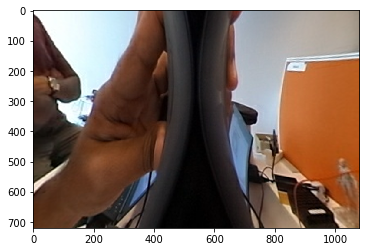

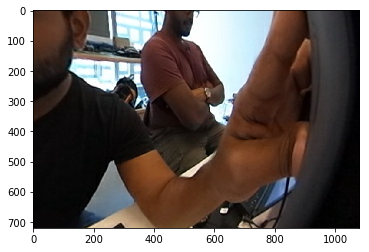

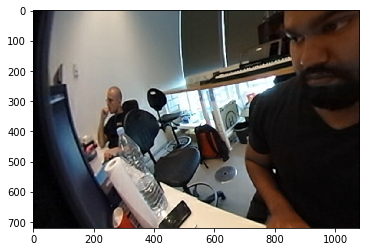

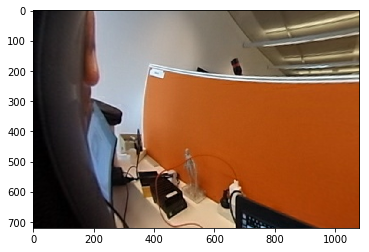

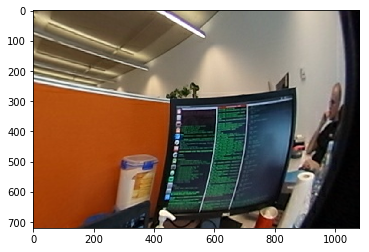

In [162]:

plt.figure(1)
plt.imshow(img1)
plt.figure(2)
plt.imshow(img2)
plt.figure(3)
plt.imshow(img3)
plt.figure(4)
plt.imshow(img4)
plt.figure(5)
plt.imshow(img5)


plt.show()

In [9]:
cv_image.shape

(720, 1280, 3)

In [19]:
temp = cv_image[0:640,0:640]

In [20]:
temp.shape

(640, 640, 3)

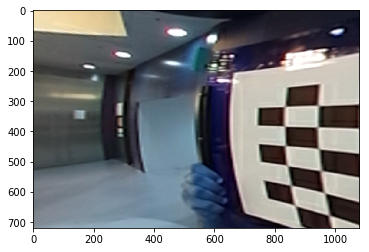

In [4]:
plt.imshow(img)

plt.show()

In [27]:
(h, w) = temp.shape[:2]
# calculate the center of the image
center = (w / 2, h / 2)
angle90 = -90
scale = 1.0

M = cv2.getRotationMatrix2D(center, angle90, scale)
rotated90 = cv2.warpAffine(temp, M, (h, w))

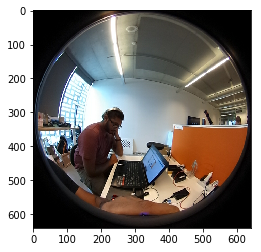

In [28]:
plt.imshow(rotated90)

plt.show()